In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import sagemaker

print(sagemaker.__version__)
sess = sagemaker.Session()
role = 'arn:aws:iam::678287862391:role/service-role/AmazonSageMaker-ExecutionRole-20220413T144048'

2.86.0


### Download the dataset

In [3]:
'''
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('D:/flower_classification_al/data', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
'''

'\ndataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"\ndata_dir = tf.keras.utils.get_file(\'D:/flower_classification_al/data\', origin=dataset_url, untar=True)\ndata_dir = pathlib.Path(data_dir)\n'

In [4]:
### get the count
import glob
my_path = "../../data/"
files = glob.glob(my_path + '/**/*.jpg', recursive=True)
len(files)

3670

### Train outside of SageMaker (just like on your laptop):  'script mode'

In [5]:
#Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

data_dir = '../../data'
train_dir = '../../data_dir/train_dir'
val_dir = '../../data_dir/val_dir'

In [6]:
## Number of GPU 
# Number of GPUs on this machine
%env SM_NUM_GPUS=0
# Where to save the model
%env SM_MODEL_DIR=D:/flower_classification_al/tmp/model
# parent directory
%env parent_direct = D:/flower_classification_al/data
# Where the training data is
%env SM_CHANNEL_TRAINING=D:/flower_classification_al/data_dir/train_dir
# Where the validation data is
%env SM_CHANNEL_VALIDATION=D:/flower_classification_al/data_dir/val_dir

%env num_classes=5
%env batch_size=32
%env image_height=180
%env image_width=180

!/bin/rm -rf $SM_MODEL_DIR
!python D:/flower_classification_al/source/train.py --epochs 1

env: SM_NUM_GPUS=0
env: SM_MODEL_DIR=D:/flower_classification_al/tmp/model
env: parent_direct=D:/flower_classification_al/data
env: SM_CHANNEL_TRAINING=D:/flower_classification_al/data_dir/train_dir
env: SM_CHANNEL_VALIDATION=D:/flower_classification_al/data_dir/val_dir
env: num_classes=5
env: batch_size=32
env: image_height=180
env: image_width=180


The system cannot find the path specified.



Model Sub-Classing API

51/92 [===============>..............] - ETA: 4s - loss: 1.5326 - accuracy: 0.3199

2022-06-20 02:07:05.632862: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 02:07:07.901595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4634 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1
2022-06-20 02:07:16.328884: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202



92/92 [==============================] - 25s 151ms/step - loss: 1.3959 - accuracy: 0.4002 - val_loss: 1.0570 - val_accuracy: 0.5858


###  Train on the notebook instance (aka 'local mode')

In [8]:
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='../../source/train.py', 
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='local',
                          framework_version='1.15', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 1}
                         )

train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Windows Support for Local Mode is Experimental


In [9]:
train_ds = tf.data.experimental.load('../../data_dir/train_dir')
val_ds = tf.data.experimental.load('../../data_dir/val_dir')

In [12]:
train_p = 'file://' + 'D:/flower_classification_al/data_dir/train_dir/dataset_spec.pb'
val_p = 'file://' + 'D:/flower_classification_al/data_dir/val_dir/dataset_spec.pb'

In [14]:
tf_estimator.fit({'training': train_p, 'validation': val_p})

In [10]:
val_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

### Visulalize training results

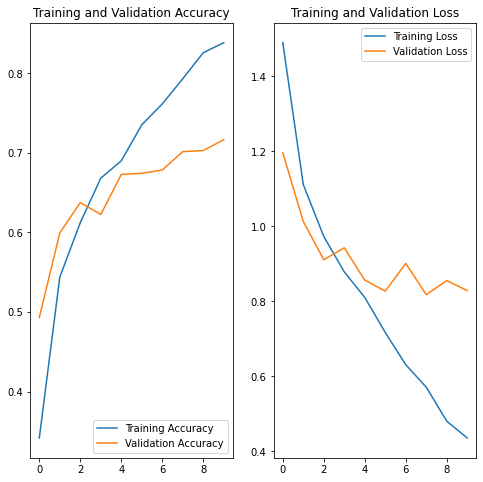

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Predict on new data

In [55]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = sub_class_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 93.40 percent confidence.


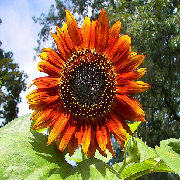

In [56]:
img

### Save the model weights

In [67]:
path = '../saved_model/my_classifier.h5'
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
sub_class_model.save_weights(path)

In [68]:
sub_class_model.load_weights(path)